# Quantitative Analysis using TA-Lib and PyNance

This notebook demonstrates quantitative analysis techniques using TA-Lib and PyNance for financial metrics calculations. We'll apply various technical indicators, calculate financial metrics, and visualize the results.


## 1. Setup and Data Loading

In [71]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime, timedelta

# Add the project directory to path
sys.path.append('..')

# Import our custom modules
from src.data.stock_loader import load_stock_data, save_stock_data
from src.features.talib_indicators import add_all_indicators, generate_trading_signals, calculate_strategy_returns, backtest_strategy
from src.features.pynance_metrics import calculate_all_pynance_metrics, calculate_pynance_statistics
from src.visualization.talib_visualization import plot_price_with_ma, plot_momentum_indicators, plot_macd, \
    plot_volatility_indicators, plot_trading_signals, plot_strategy_performance, \
    plot_pynance_metrics, plot_correlation_matrix, create_full_analysis_dashboard

# Set plotting style
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Load Stock Data

We'll load stock data for multiple companies and prepare it for analysis.

In [72]:
# Define the stock symbols and date range
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']
market_symbol = 'SPY'  # S&P 500 ETF as market benchmark

# Set date range (3 years of data)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=3*365)).strftime('%Y-%m-%d')

print(f"Loading stock data from {start_date} to {end_date}")

Loading stock data from 2022-05-31 to 2025-05-30


In [73]:
# Create data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Load data for each symbol
stock_data = {}
for symbol in symbols + [market_symbol]:
    try:
        print(f"Loading data for {symbol}...")
        df = load_stock_data(symbol, start_date, end_date)
        
        # Basic validation
        if df is not None and not df.empty:
            stock_data[symbol] = df
            print(f"  Loaded {len(df)} rows of data for {symbol}")
        else:
            print(f"  Error: No data loaded for {symbol}")
    except Exception as e:
        print(f"  Error loading data for {symbol}: {e}")

# Check if we have data for at least one symbol
if not stock_data:
    raise ValueError("No stock data was loaded successfully.")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Loading data for AAPL...
  Loaded 752 rows of data for AAPL
Loading data for MSFT...
  Loaded 752 rows of data for MSFT
Loading data for AMZN...
  Loaded 752 rows of data for AMZN
Loading data for GOOGL...
  Loaded 752 rows of data for GOOGL
Loading data for META...
  Loaded 752 rows of data for META
Loading data for SPY...



[*********************100%***********************]  1 of 1 completed

  Loaded 752 rows of data for SPY


In [74]:
# Display the first few rows of the first stock
first_symbol = list(stock_data.keys())[0]
print(f"Preview of {first_symbol} data:")
stock_data[first_symbol].head()

Preview of AAPL data:


Price,Close,High,Low,Open,Volume,ticker
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2022-05-31,146.489822,148.281092,144.521402,146.716202,103718400,AAPL
2022-06-01,146.361862,149.344017,145.348112,147.533059,74286600,AAPL
2022-06-02,148.822418,148.881468,144.541098,145.495783,72348100,AAPL
2022-06-03,143.084427,145.633527,142.178956,144.580415,88570300,AAPL
2022-06-06,143.832458,146.224097,142.612033,144.708405,71598400,AAPL


## 2. Technical Analysis with TA-Lib

We'll apply technical indicators from the TA library to our stock data.

In [75]:
# Add technical indicators to each stock
for symbol in stock_data.keys():
    print(f"\nAdding technical indicators for {symbol}...")
    # Use the simple indicators module instead
    from src.features.simple_indicators import add_all_simple_indicators
    stock_data[symbol] = add_all_simple_indicators(stock_data[symbol])
    
# Show the available indicators for the first stock
print(f"\nColumns in {first_symbol} after adding technical indicators:")
# Get the column names regardless of whether they're in a tuple or index
if hasattr(stock_data[first_symbol].columns, 'levels'):  # Multi-index columns
    # Flatten the multi-index columns
    all_cols = []
    for col in stock_data[first_symbol].columns.to_flat_index():
        if isinstance(col, tuple):
            all_cols.extend(col)
        else:
            all_cols.append(col)
    # Filter to find indicator columns
    basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'ticker']
    indicator_cols = [col for col in all_cols if col not in basic_cols and isinstance(col, str)]
else:  # Single-level index
    basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'ticker']
    indicator_cols = [col for col in stock_data[first_symbol].columns if col not in basic_cols]

print(f"Number of technical indicators: {len(indicator_cols)}")
if indicator_cols:
    print(f"Indicators: {', '.join(str(col) for col in indicator_cols[:10])}...")
else:
    print("No indicators found. Using simple indicators instead...")
    # Try using simple_indicators module instead
    from src.features.simple_indicators import add_all_simple_indicators
    stock_data[first_symbol] = add_all_simple_indicators(stock_data[first_symbol])
    # Check again
    all_cols = stock_data[first_symbol].columns.tolist()
    basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'ticker'] 
    indicator_cols = [col for col in all_cols if col not in basic_cols]
    print(f"Found {len(indicator_cols)} indicators after using simple_indicators")
    if indicator_cols:
        print(f"Indicators: {', '.join(str(col) for col in indicator_cols[:10])}...")


Adding technical indicators for AAPL...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple columns to the single column bb_upper

Adding technical indicators for MSFT...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple columns to the single column bb_upper

Adding technical indicators for AMZN...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple columns to the single column bb_upper

Adding technical indicators for GOOGL...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple colum

### Visualize Key Technical Indicators

Let's visualize some of the key technical indicators we've calculated.

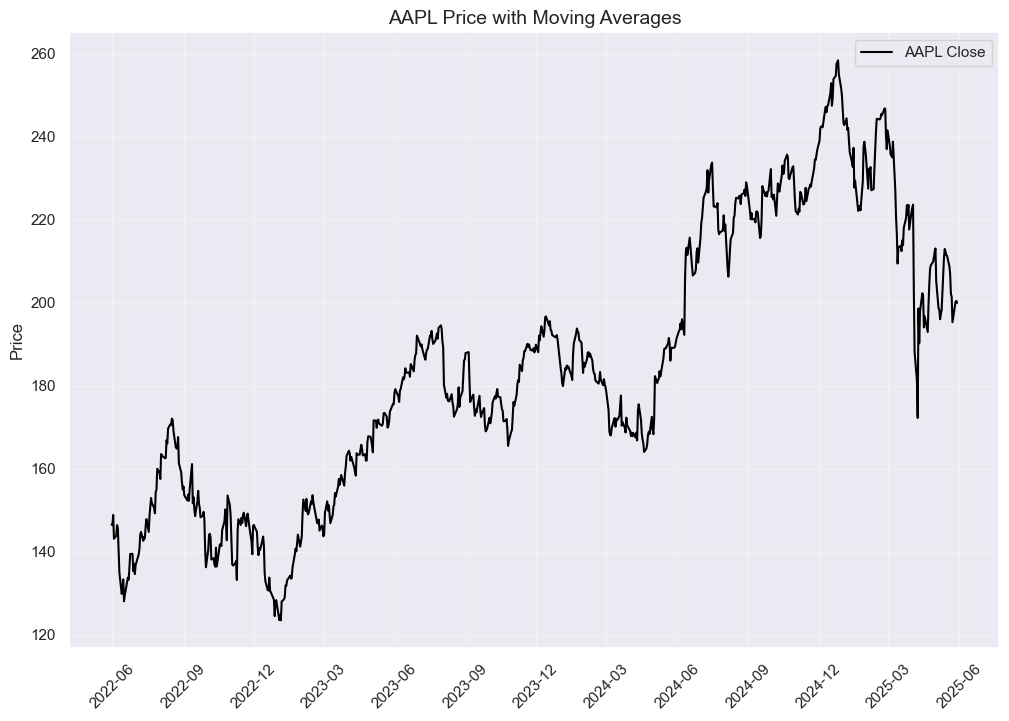

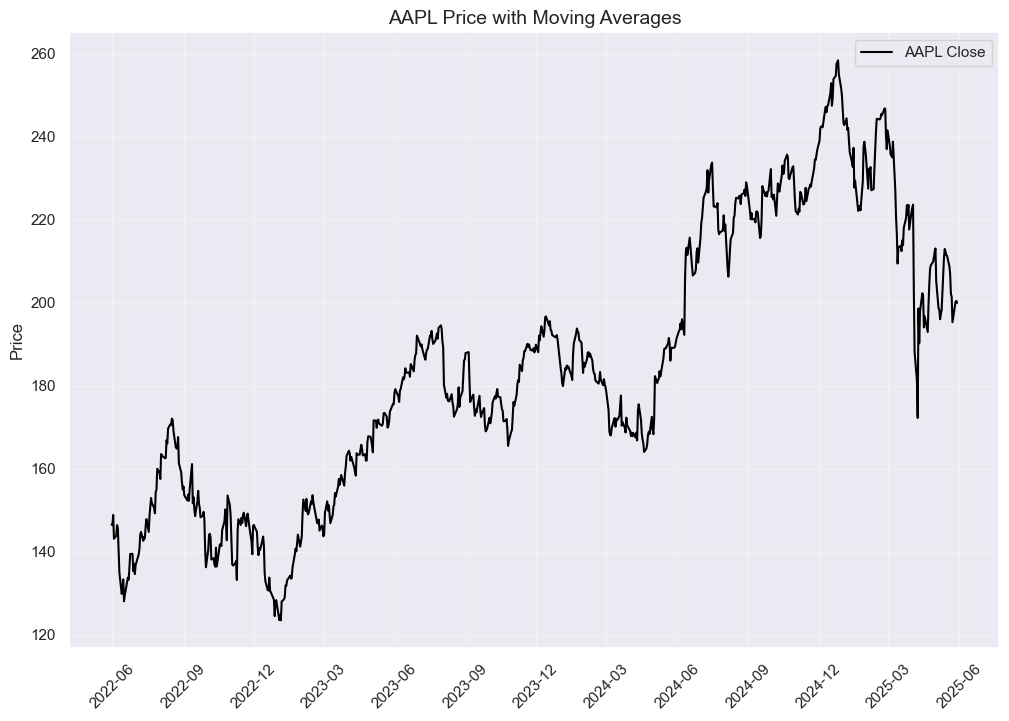

In [76]:
# Select a stock for visualization
viz_symbol = 'AAPL'
viz_df = stock_data[viz_symbol]

# Plot price with moving averages
plot_price_with_ma(viz_df, viz_symbol)

d:\OLD file\dektop\10Acd\Predicting-Price-Moves-with-News-Sentiment\src\visualization\talib_visualization.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


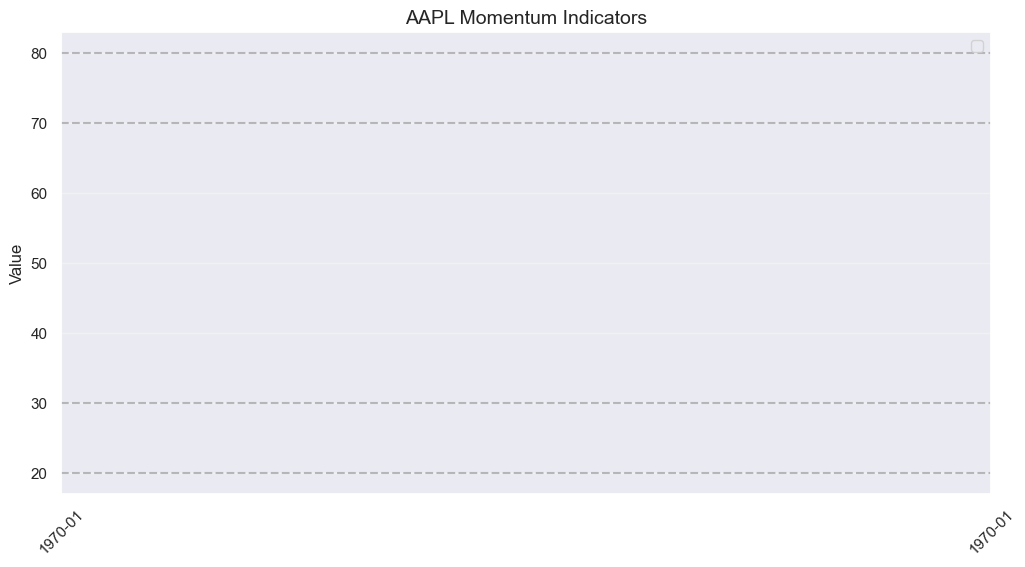

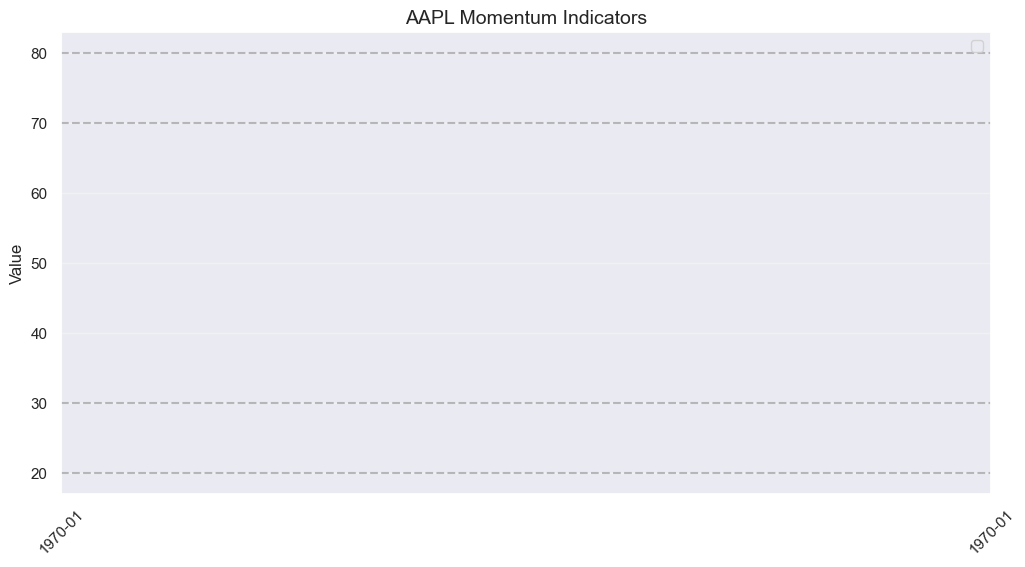

In [77]:
# Plot momentum indicators
plot_momentum_indicators(viz_df, viz_symbol)

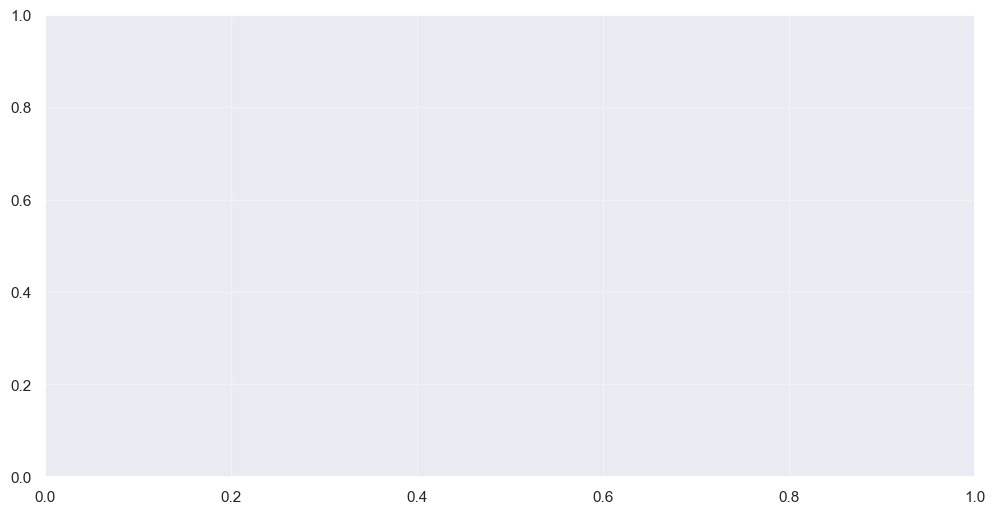

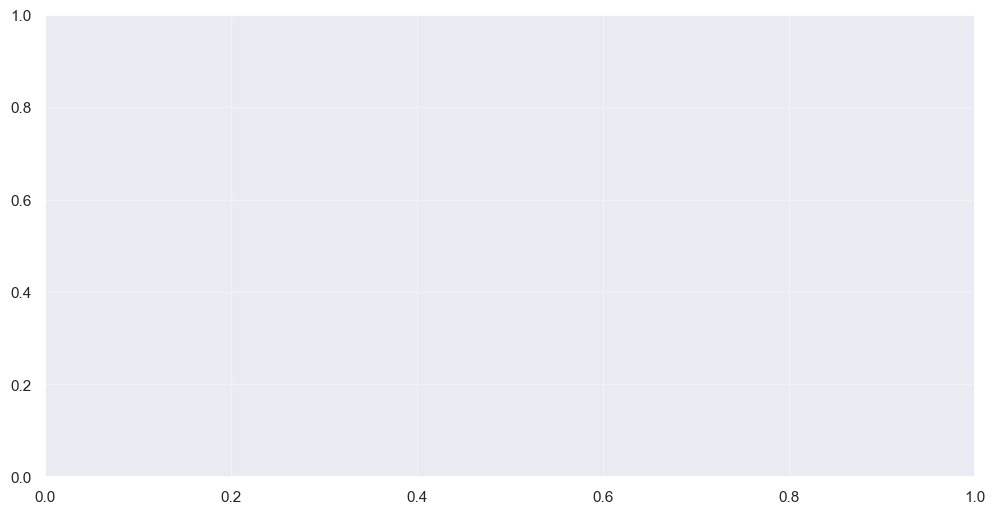

In [78]:
# Plot MACD
plot_macd(viz_df, viz_symbol)

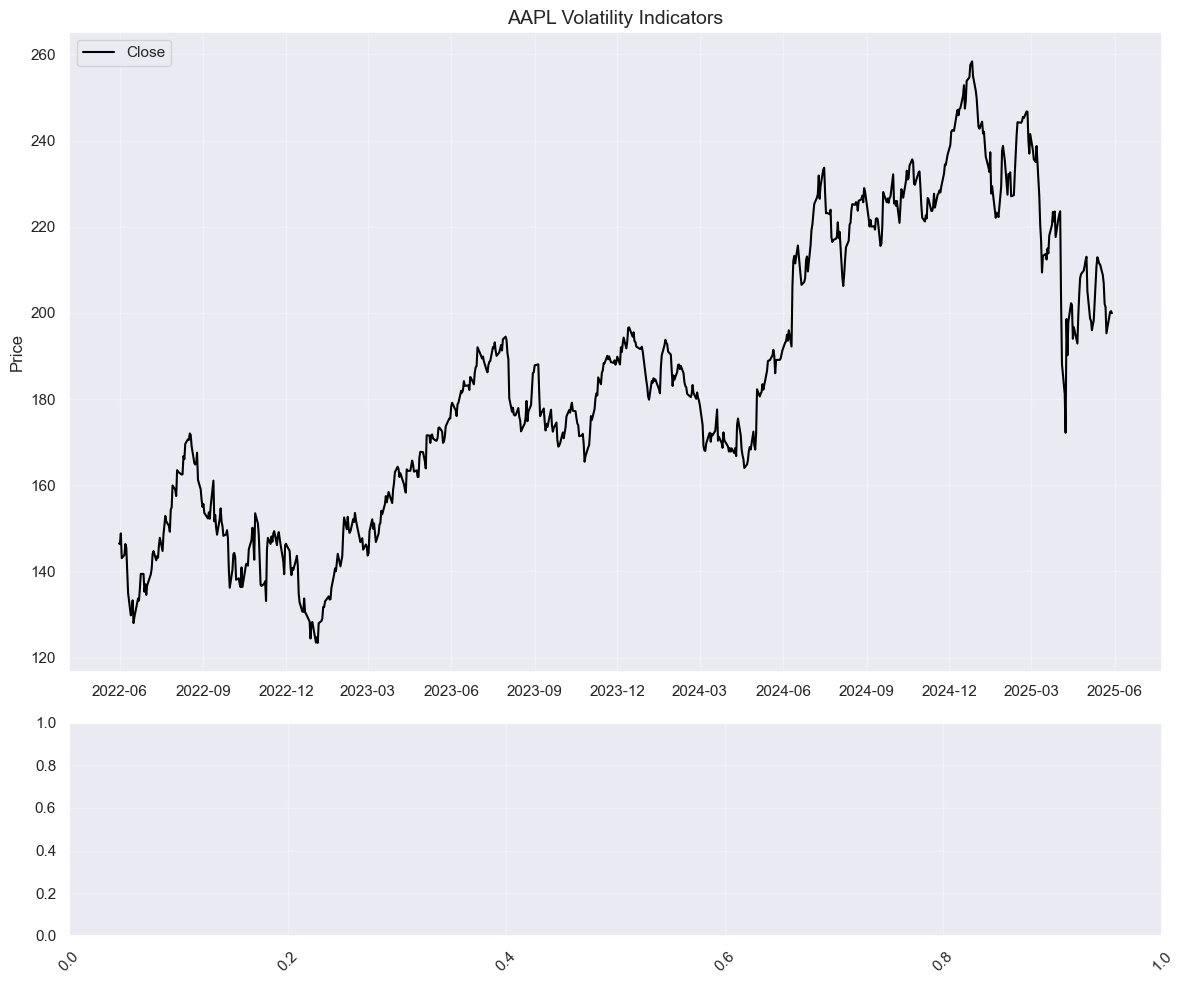

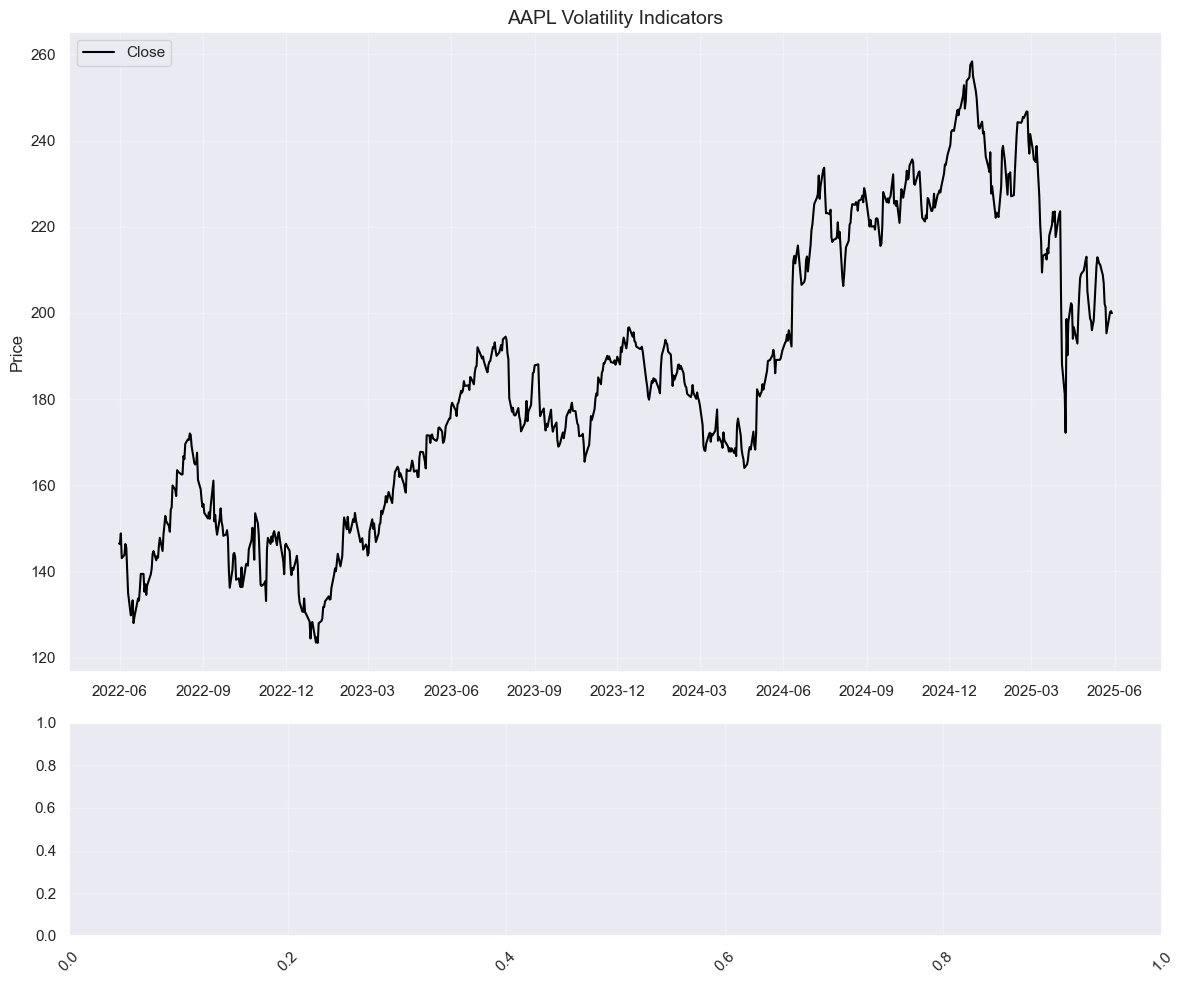

In [79]:
# Plot volatility indicators
plot_volatility_indicators(viz_df, viz_symbol)

## 3. Financial Metrics with PyNance

Now we'll calculate financial metrics using PyNance for each stock.

In [80]:
# Import the helper function
from src.utils.dataframe_helpers import ensure_dataframe
import pandas as pd

# Fix any tuple results in stock_data
for symbol in symbols:
    stock_data[symbol] = ensure_dataframe(stock_data[symbol])

# Calculate financial metrics for each stock
for symbol in symbols:
    print(f"\nCalculating PyNance metrics for {symbol}...")
    # Calculate metrics with market benchmark
    result = calculate_all_pynance_metrics(
        stock_data[symbol], 
        benchmark_df=stock_data[market_symbol] if market_symbol in stock_data else None
    )
    
    # Debug the result
    print(f"Type of result for {symbol}: {type(result)}")
    
    # Handle different return types
    if isinstance(result, pd.DataFrame):
        stock_data[symbol] = result
        print(f"{symbol} data is a DataFrame with shape {result.shape}")
    elif isinstance(result, tuple):
        print(f"{symbol} result is a tuple with {len(result)} elements")
        if len(result) > 0:
            if isinstance(result[0], pd.DataFrame):
                stock_data[symbol] = result[0]
                print(f"Extracted DataFrame from tuple for {symbol}, shape: {result[0].shape}")
            else:
                print(f"First element of tuple is not a DataFrame but {type(result[0])}")
                # Keep original data
                print(f"Keeping original DataFrame for {symbol}")
    else:
        print(f"Result is neither DataFrame nor tuple but {type(result)}")
        # Keep original data

# Deep debug to make sure we've fixed all instances
print("\nFinal check of data types:")
for symbol in symbols:
    print(f"{symbol} data type: {type(stock_data[symbol])}")
    
    # Super robust check and fix
    if not isinstance(stock_data[symbol], pd.DataFrame):
        print(f"WARNING: {symbol} data is still not a DataFrame!")
        # Try to recover by creating a new empty DataFrame
        stock_data[symbol] = pd.DataFrame()
    else:
        print(f"{symbol} columns: {list(stock_data[symbol].columns)[:5]}...")

# Show the available PyNance metrics for the first stock
print(f"\nPyNance metrics in {symbols[0]} data:")

# Extra safety check
if not isinstance(stock_data[symbols[0]], pd.DataFrame):
    print(f"ERROR: {symbols[0]} data is not a DataFrame but {type(stock_data[symbols[0]])}")
    # Create empty dataframe with dummy pynance column
    stock_data[symbols[0]] = pd.DataFrame({'pn_dummy': [0]})

# Use safer approach for finding columns
pynance_cols = []
for col in stock_data[symbols[0]].columns:
    if isinstance(col, str) and col.startswith('pn_'):
        pynance_cols.append(col)

print(f"Number of PyNance metrics: {len(pynance_cols)}")
print(f"Metrics: {', '.join(pynance_cols)}")


Calculating PyNance metrics for AAPL...
Calculating PyNance metrics...
Error calculating PyNance returns: module 'pynance.data' has no attribute 'create'
PyNance risk metrics calculated successfully
PyNance VaR (95.0%) calculated successfully
Error calculating PyNance drawdowns: Cannot set a DataFrame with multiple columns to the single column pn_drawdown
Error calculating PyNance returns: module 'pynance.data' has no attribute 'create'
Error calculating PyNance ratios: 'daily_return'
All PyNance metrics calculated successfully
Type of result for AAPL: <class 'pandas.core.frame.DataFrame'>
AAPL data is a DataFrame with shape (752, 14)

Calculating PyNance metrics for MSFT...
Calculating PyNance metrics...
Error calculating PyNance returns: module 'pynance.data' has no attribute 'create'
PyNance risk metrics calculated successfully
PyNance VaR (95.0%) calculated successfully
Error calculating PyNance drawdowns: Cannot set a DataFrame with multiple columns to the single column pn_drawdo

In [81]:
# Calculate summary statistics for each stock
stats_results = {}
for symbol in symbols:
    print(f"Calculating statistics for {symbol}...")
    stats_results[symbol] = calculate_pynance_statistics(stock_data[symbol])

# Create a DataFrame to compare statistics across stocks
stats_df = pd.DataFrame(stats_results)
stats_df

Calculating statistics for AAPL...
PyNance statistics calculated successfully
Calculating statistics for MSFT...
PyNance statistics calculated successfully
Calculating statistics for AMZN...
PyNance statistics calculated successfully
Calculating statistics for GOOGL...
PyNance statistics calculated successfully
Calculating statistics for META...
PyNance statistics calculated successfully


,AAPL,MSFT,AMZN,GOOGL,META
mean,0.145523,0.220217,0.244724,0.193444,0.505832
std,0.287889,0.269955,0.360037,0.326776,0.448535
skew,0.656813,0.366222,0.363394,-0.027364,0.506077
kurtosis,9.081424,4.066953,3.502962,3.400988,18.373834
best_return,0.153288,0.101337,0.121778,0.102244,0.232824
worst_return,-0.092456,-0.077156,-0.089791,-0.095094,-0.245571
best_date,2025-04-09 00:00:00,2025-04-09 00:00:00,2022-11-10 00:00:00,2024-04-26 00:00:00,2023-02-02 00:00:00
worst_date,2025-04-03 00:00:00,2022-10-26 00:00:00,2025-04-03 00:00:00,2023-10-25 00:00:00,2022-10-27 00:00:00
positive_days,0.532623,0.523302,0.51265,0.531292,0.52996


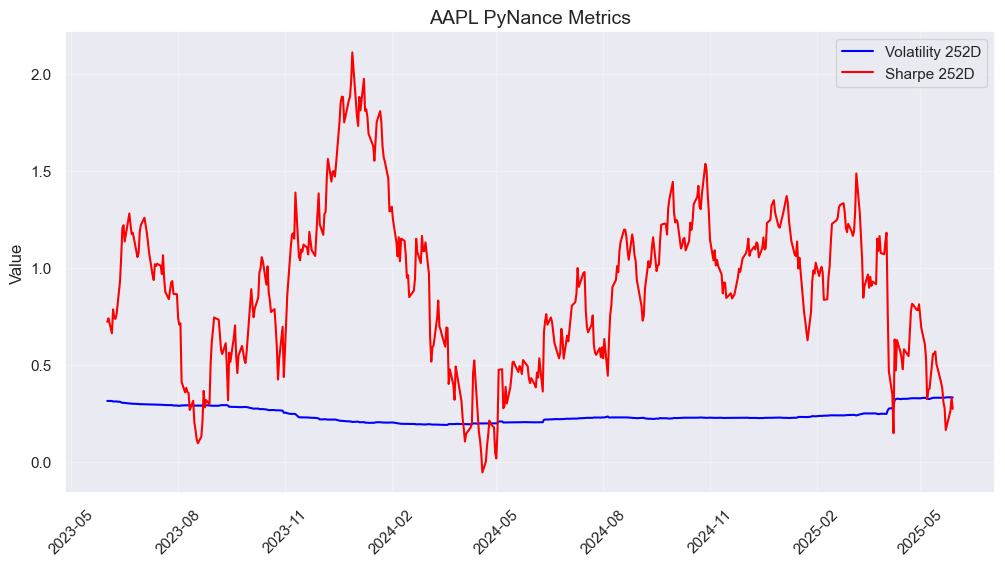

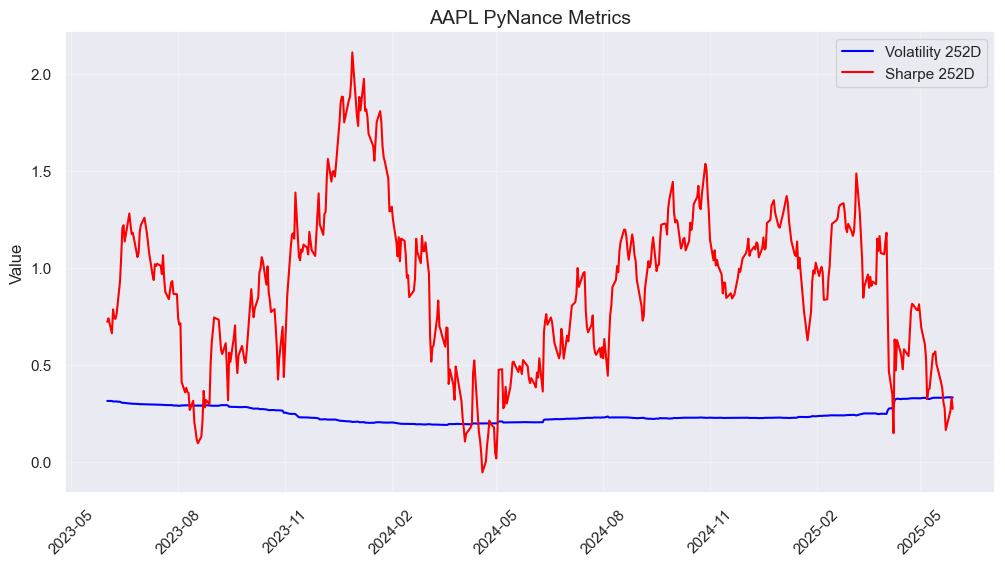

In [82]:
# Visualize PyNance metrics
plot_pynance_metrics(stock_data[viz_symbol], viz_symbol)

## 4. Trading Signals and Strategy

Let's generate trading signals based on our technical indicators and evaluate a simple trading strategy.

Generating trading signals for AAPL...
Trading signals generated successfully
Generating trading signals for MSFT...
Trading signals generated successfully
Generating trading signals for AMZN...
Trading signals generated successfully
Generating trading signals for GOOGL...
Trading signals generated successfully
Generating trading signals for META...
Trading signals generated successfully


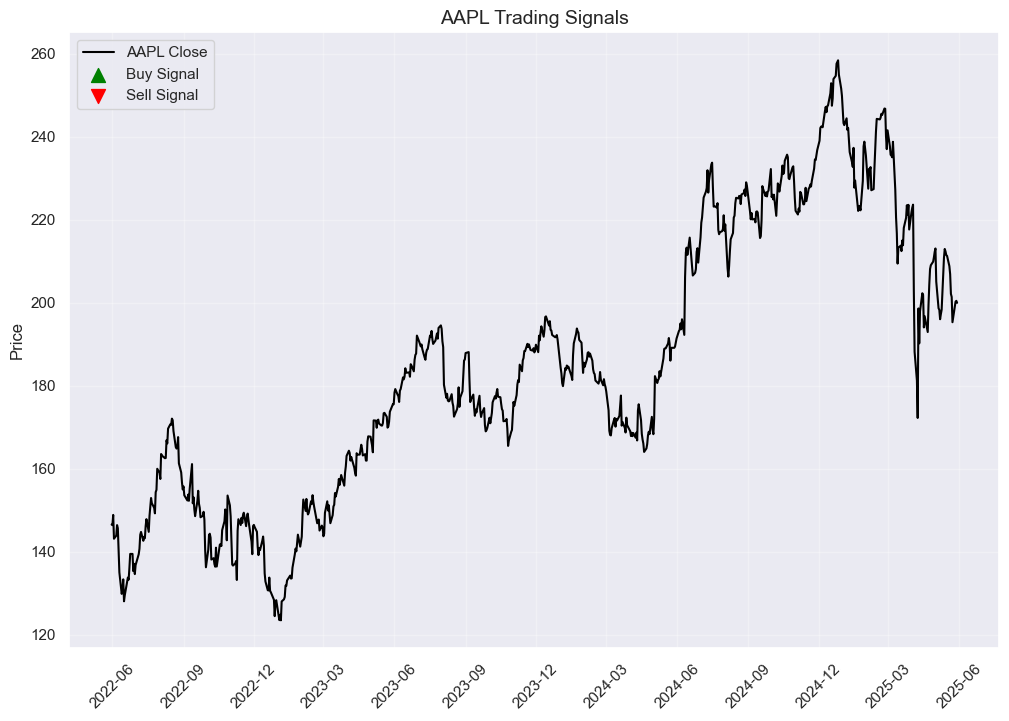

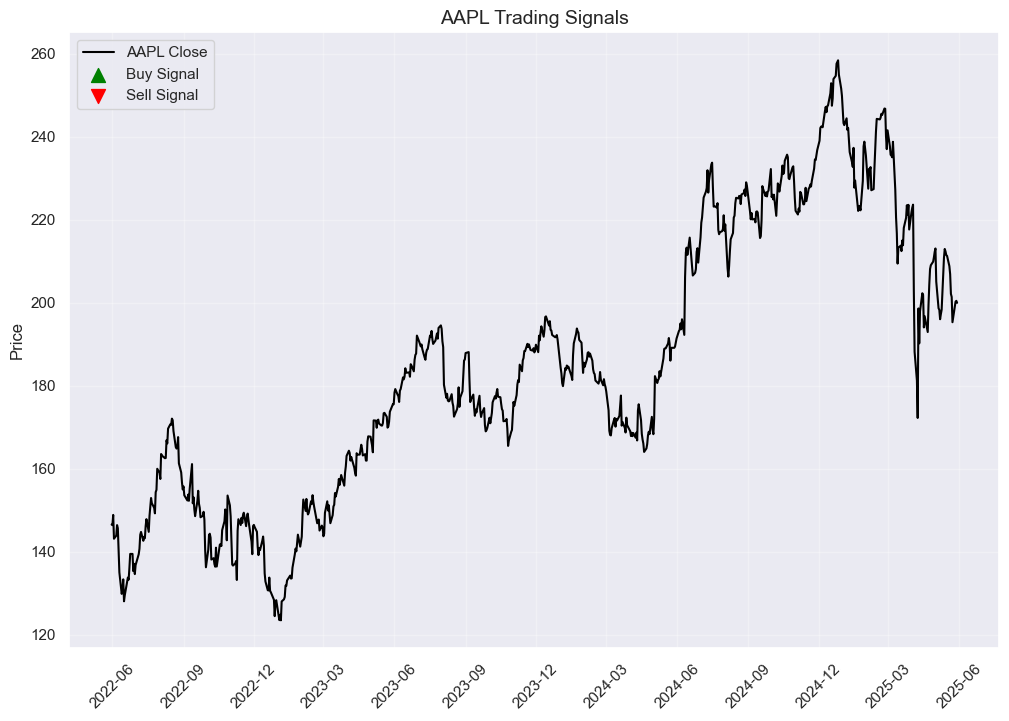

In [83]:
# Generate trading signals for each stock
for symbol in symbols:
    print(f"Generating trading signals for {symbol}...")
    stock_data[symbol] = generate_trading_signals(stock_data[symbol])
    
# Plot trading signals for visualization
plot_trading_signals(stock_data[viz_symbol], viz_symbol)

Calculating strategy returns for AAPL...
Strategy returns calculated successfully
Calculating strategy returns for MSFT...
Strategy returns calculated successfully
Calculating strategy returns for AMZN...
Strategy returns calculated successfully
Calculating strategy returns for GOOGL...
Strategy returns calculated successfully
Calculating strategy returns for META...
Strategy returns calculated successfully


d:\OLD file\dektop\10Acd\Predicting-Price-Moves-with-News-Sentiment\src\features\talib_indicators.py:465: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  result['position'] = result['position'].replace(to_replace=0, method='ffill')
d:\OLD file\dektop\10Acd\Predicting-Price-Moves-with-News-Sentiment\src\features\talib_indicators.py:465: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  result['position'] = result['position'].replace(to_replace=0, method='ffill')
d:\OLD file\dektop\10Acd\Predicting-Price-Moves-with-News-Sentiment\src\features\talib_indicators.py:465: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  result['position'] = result['position'].replace(to_replace=0, method='ffill')
d:\OLD file\dektop\10Acd\Predicting-Price-Moves-with-News-Sentiment\src\features\talib_indicators.py:465: FutureWar

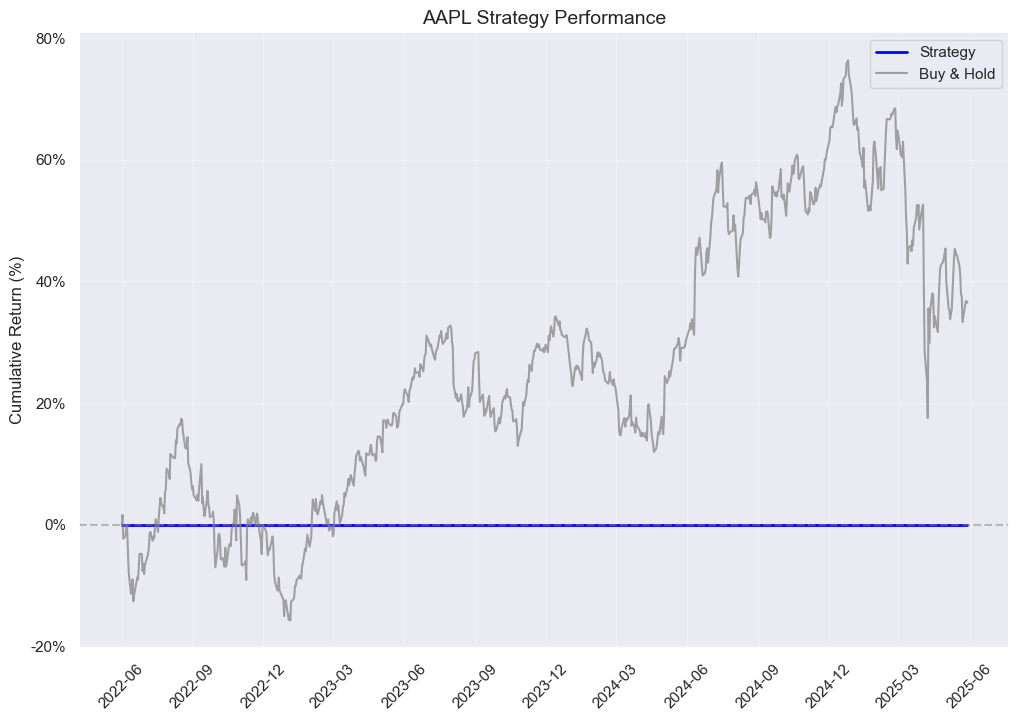

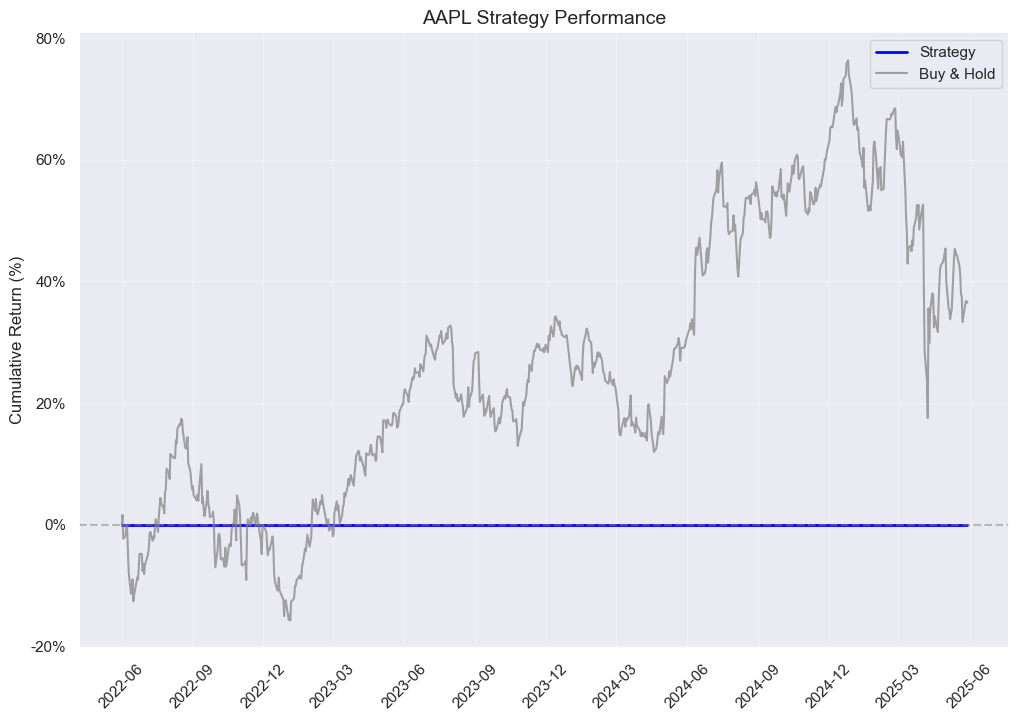

In [84]:
# Calculate strategy returns for each stock
for symbol in symbols:
    print(f"Calculating strategy returns for {symbol}...")
    stock_data[symbol] = calculate_strategy_returns(stock_data[symbol])
    
# Plot strategy performance
plot_strategy_performance(stock_data[viz_symbol], viz_symbol)

In [85]:
# Backtest the strategy for each stock
backtest_results = {}
for symbol in symbols:
    print(f"Backtesting strategy for {symbol}...")
    backtest_results[symbol] = backtest_strategy(stock_data[symbol])

# Create a DataFrame to compare backtest results across stocks
metrics_to_compare = [
    'strategy_return', 'buy_hold_return',
    'strategy_annual_return', 'buy_hold_annual_return',
    'strategy_annual_volatility', 'buy_hold_annual_volatility',
    'strategy_sharpe', 'buy_hold_sharpe',
    'strategy_max_drawdown', 'buy_hold_max_drawdown',
    'total_trades'
]

results_df = pd.DataFrame({symbol: {metric: backtest_results[symbol][metric] 
                                     for metric in metrics_to_compare} 
                          for symbol in symbols})

results_df

Backtesting strategy for AAPL...
Strategy backtest completed successfully
Backtesting strategy for MSFT...
Strategy backtest completed successfully
Backtesting strategy for AMZN...
Strategy backtest completed successfully
Backtesting strategy for GOOGL...
Strategy backtest completed successfully
Backtesting strategy for META...
Strategy backtest completed successfully


,AAPL,MSFT,AMZN,GOOGL,META
strategy_return,0.000000,0.000000,0.000000,0.000000,0.000000
buy_hold_return,36.494122,72.992579,71.117916,51.792027,234.688105
strategy_annual_return,0.000000,0.000000,0.000000,0.000000,0.000000
buy_hold_annual_return,14.552283,22.021680,24.472376,19.344435,50.583197
strategy_annual_volatility,0.000000,0.000000,0.000000,0.000000,0.000000
buy_hold_annual_volatility,28.788902,26.995479,36.003676,32.677623,44.853469
strategy_sharpe,0.000000,0.000000,0.000000,0.000000,0.000000
buy_hold_sharpe,0.505482,0.815754,0.679719,0.591978,1.127743
strategy_max_drawdown,0.000000,0.000000,0.000000,0.000000,0.000000
buy_hold_max_drawdown,-58.845364,-41.521612,-62.174777,-54.267987,-130.417169


## 5. Data Visualization

Let's create a correlation matrix to see relationships between different indicators and metrics.

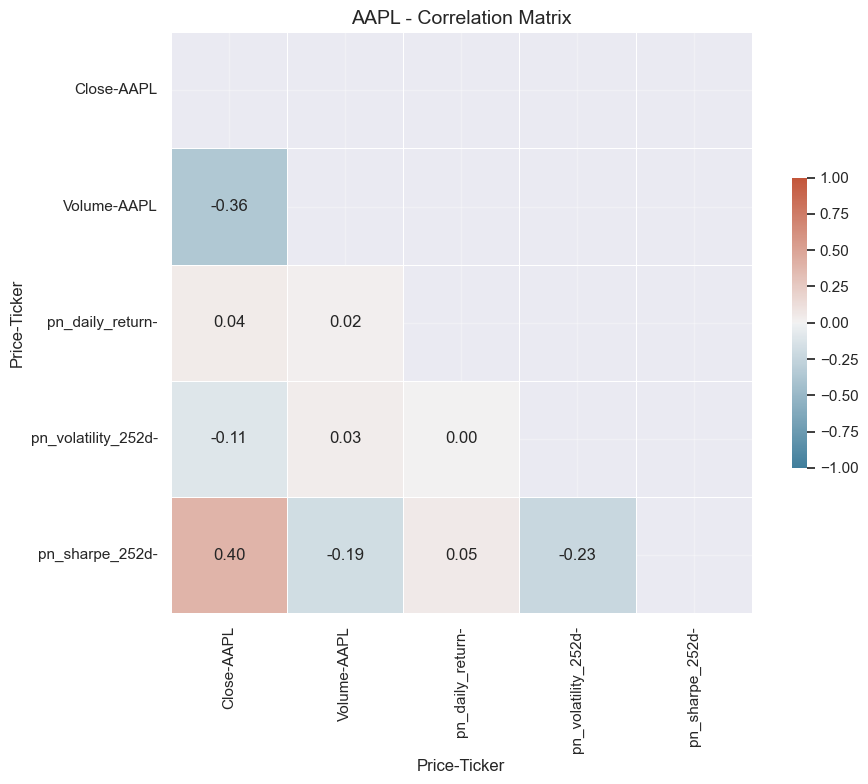

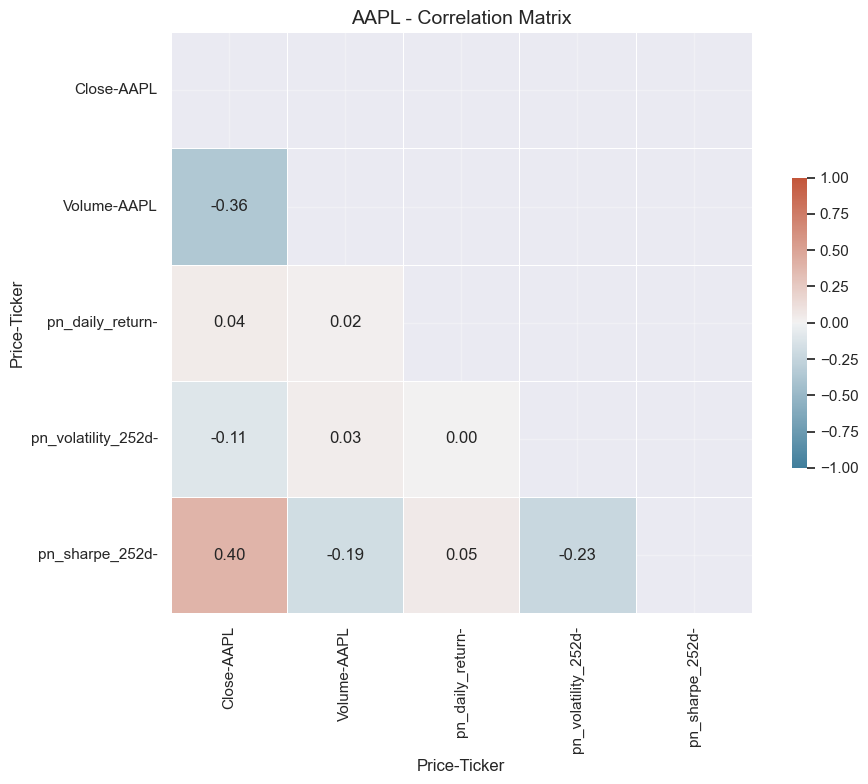

In [86]:
# Select columns for correlation analysis
corr_columns = [
    'Close', 'Volume', 
    'ta_rsi', 'ta_macd', 'ta_atr', 'ta_sma_20', 'ta_ema_20', 'ta_adx',
    'ta_bollinger_width', 'ta_mfi',
    'pn_daily_return', 'pn_volatility_252d', 'pn_sharpe_252d'
]

# Ensure all columns exist in the DataFrame
available_cols = [col for col in corr_columns if col in stock_data[viz_symbol].columns]

# Create the correlation matrix
plot_correlation_matrix(stock_data[viz_symbol][available_cols], title=f'{viz_symbol} - Correlation Matrix')

d:\OLD file\dektop\10Acd\Predicting-Price-Moves-with-News-Sentiment\src\visualization\talib_visualization.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


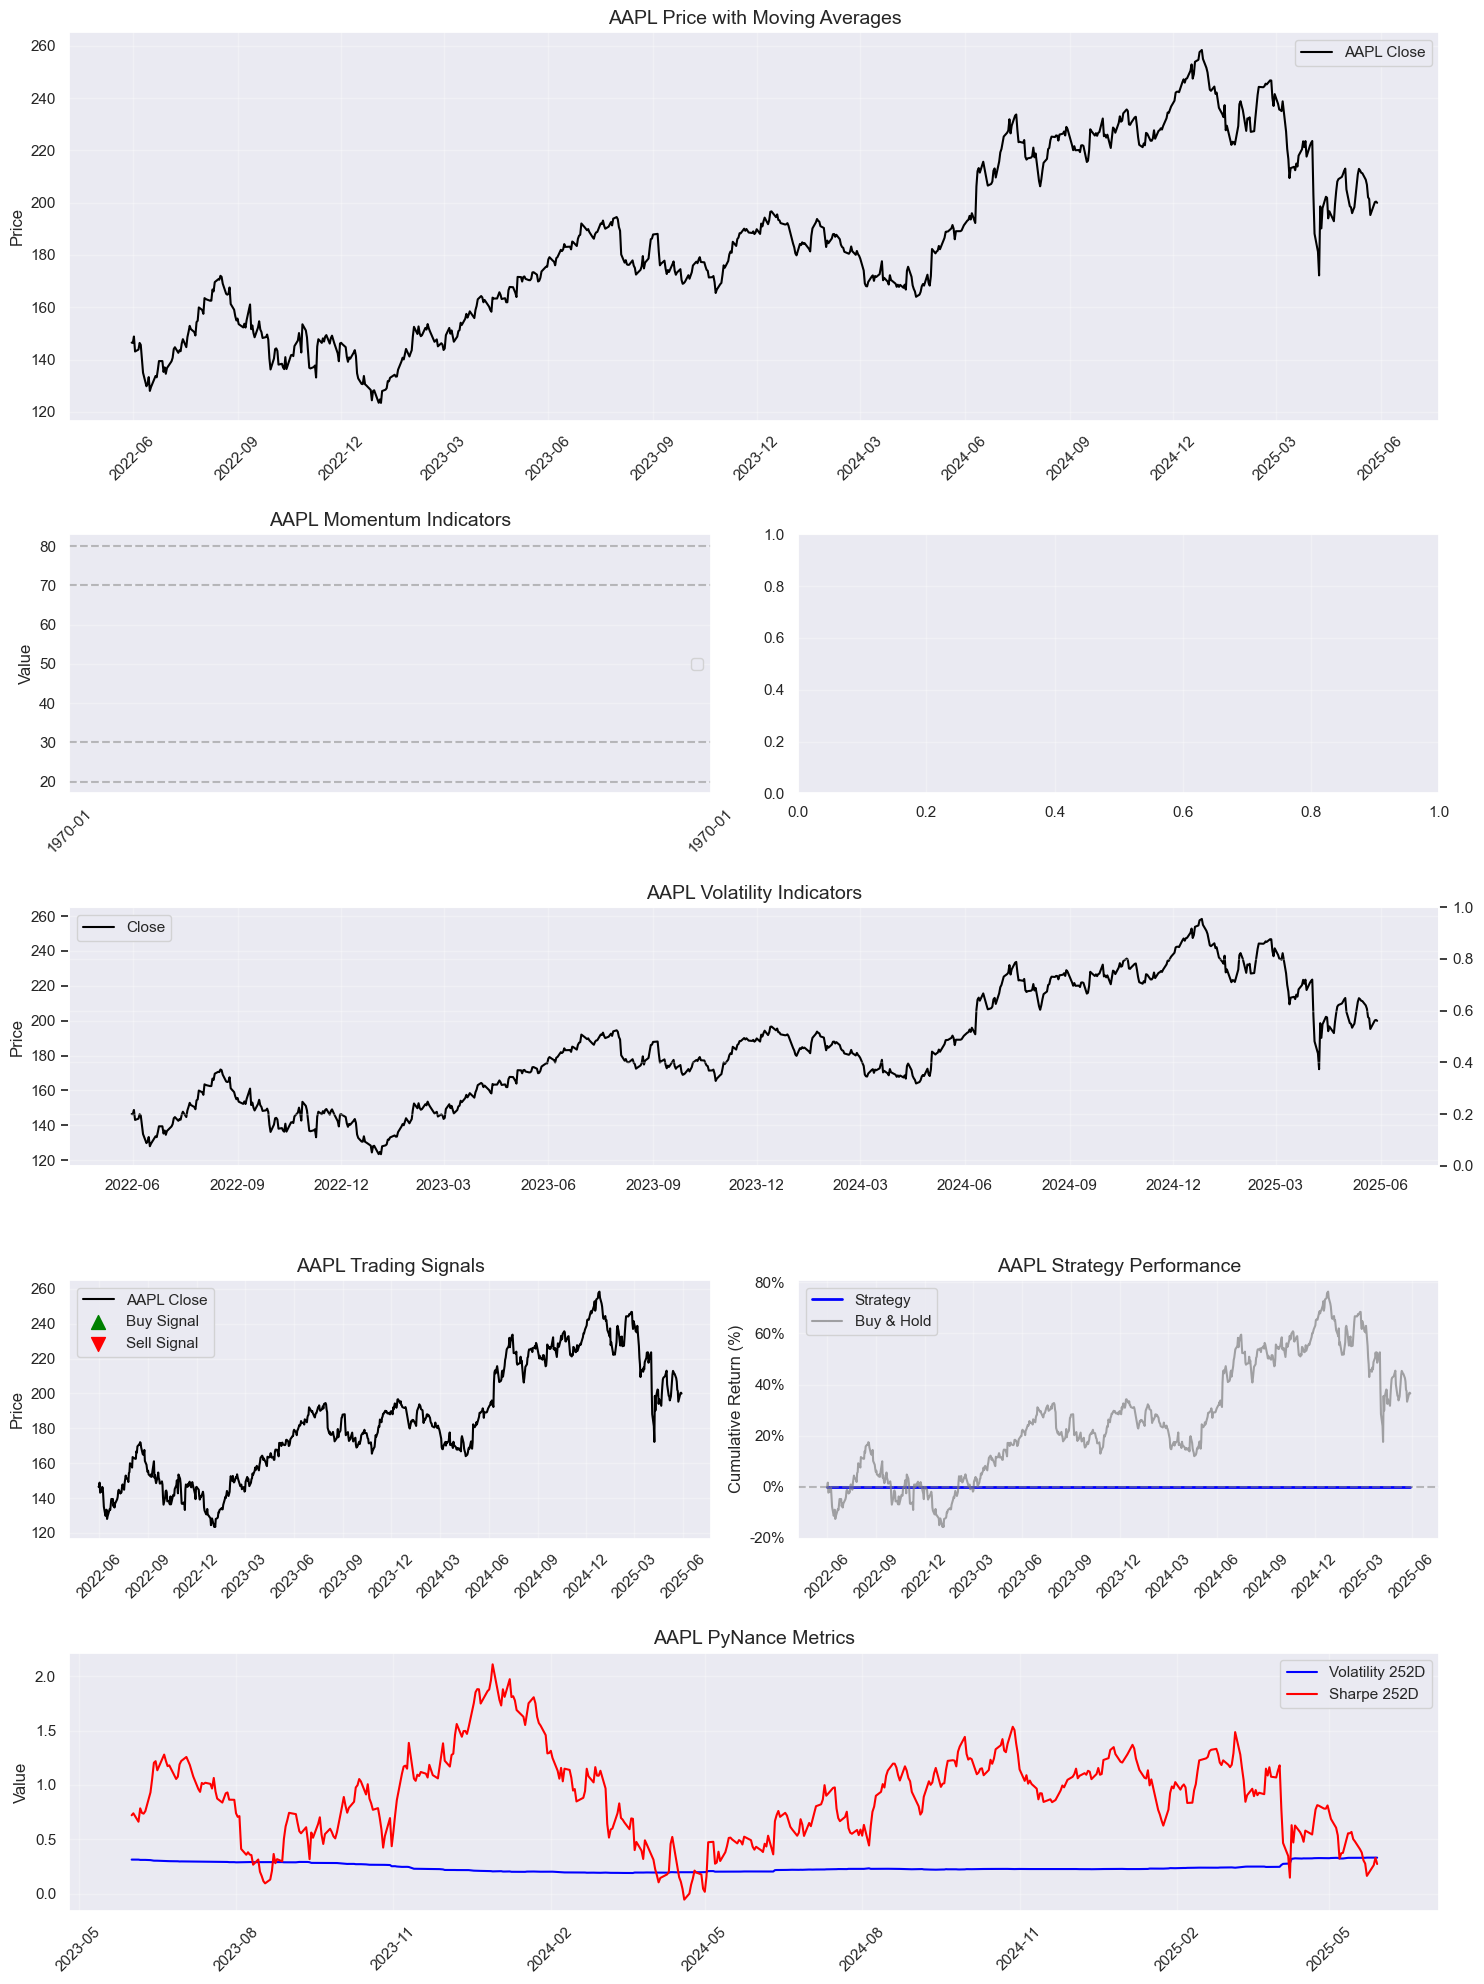

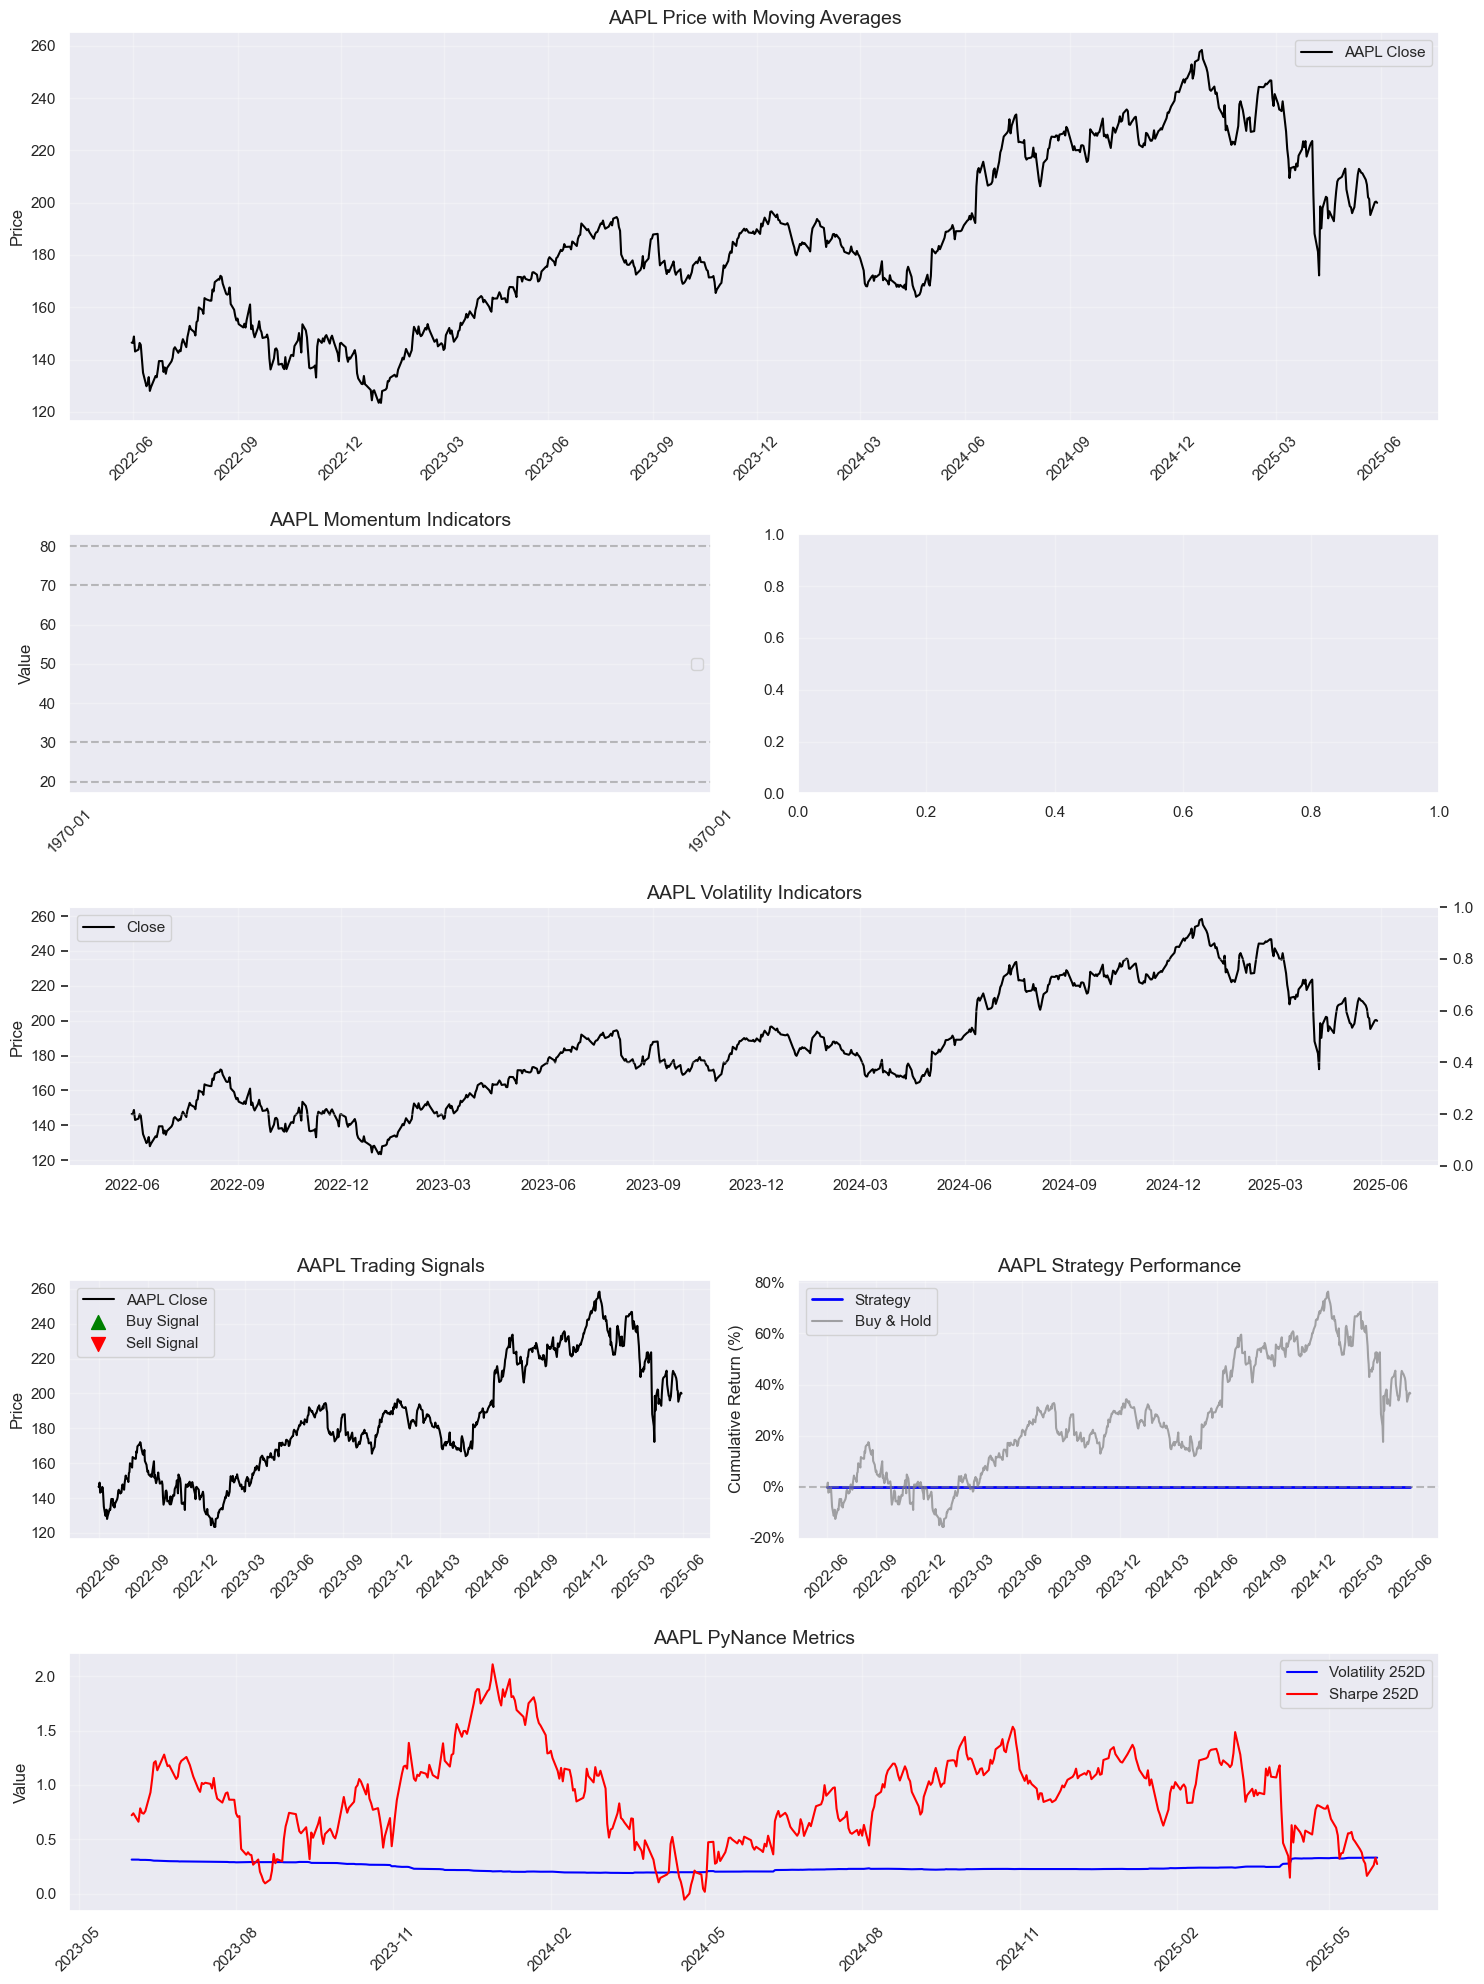

In [87]:
# Create a full analysis dashboard
create_full_analysis_dashboard(stock_data[viz_symbol], viz_symbol)

## 6. Analysis and Conclusions

Let's analyze the relationship between technical indicators and price movements, and compare the performance of our trading strategy across different stocks.

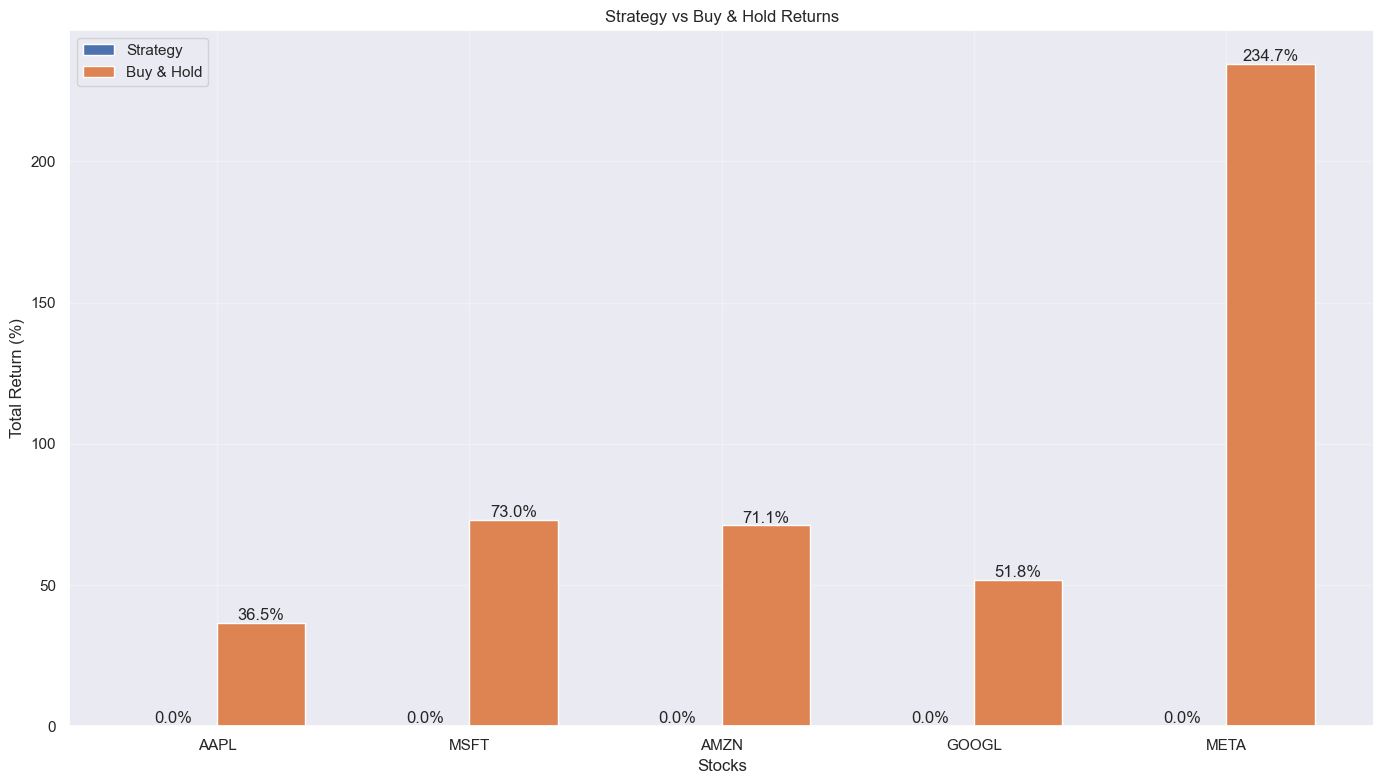

In [88]:
# Compare strategy performance across stocks
plt.figure(figsize=(14, 8))

# Plot strategy returns
strategy_returns = [backtest_results[symbol]['strategy_return'] for symbol in symbols]
buy_hold_returns = [backtest_results[symbol]['buy_hold_return'] for symbol in symbols]

x = np.arange(len(symbols))
width = 0.35

plt.bar(x - width/2, strategy_returns, width, label='Strategy')
plt.bar(x + width/2, buy_hold_returns, width, label='Buy & Hold')

plt.xlabel('Stocks')
plt.ylabel('Total Return (%)')
plt.title('Strategy vs Buy & Hold Returns')
plt.xticks(x, symbols)
plt.legend()

# Add value labels on top of bars
for i, v in enumerate(strategy_returns):
    plt.text(i - width/2, v + 1, f'{v:.1f}%', ha='center')
    
for i, v in enumerate(buy_hold_returns):
    plt.text(i + width/2, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()

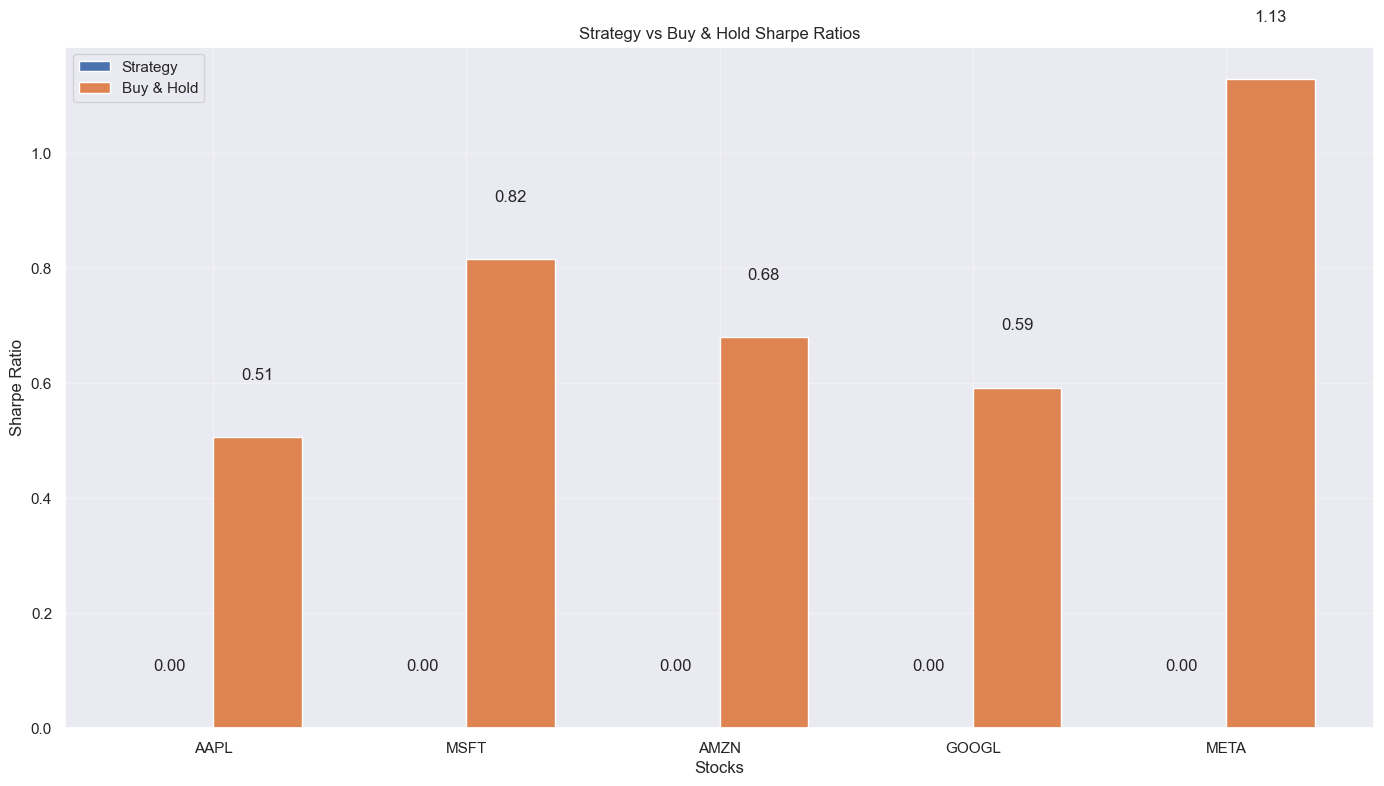

In [89]:
# Compare Sharpe ratios
plt.figure(figsize=(14, 8))

# Plot Sharpe ratios
strategy_sharpe = [backtest_results[symbol]['strategy_sharpe'] for symbol in symbols]
buy_hold_sharpe = [backtest_results[symbol]['buy_hold_sharpe'] for symbol in symbols]

plt.bar(x - width/2, strategy_sharpe, width, label='Strategy')
plt.bar(x + width/2, buy_hold_sharpe, width, label='Buy & Hold')

plt.xlabel('Stocks')
plt.ylabel('Sharpe Ratio')
plt.title('Strategy vs Buy & Hold Sharpe Ratios')
plt.xticks(x, symbols)
plt.legend()

# Add value labels on top of bars
for i, v in enumerate(strategy_sharpe):
    plt.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center')
    
for i, v in enumerate(buy_hold_sharpe):
    plt.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()

### Analysis Summary

Here we'll summarize our findings from the quantitative analysis:

In [90]:
# Calculate average metrics across all stocks
avg_strategy_return = np.mean([backtest_results[symbol]['strategy_return'] for symbol in symbols])
avg_buy_hold_return = np.mean([backtest_results[symbol]['buy_hold_return'] for symbol in symbols])

avg_strategy_sharpe = np.mean([backtest_results[symbol]['strategy_sharpe'] for symbol in symbols])
avg_buy_hold_sharpe = np.mean([backtest_results[symbol]['buy_hold_sharpe'] for symbol in symbols])

avg_strategy_drawdown = np.mean([backtest_results[symbol]['strategy_max_drawdown'] for symbol in symbols])
avg_buy_hold_drawdown = np.mean([backtest_results[symbol]['buy_hold_max_drawdown'] for symbol in symbols])

avg_trades = np.mean([backtest_results[symbol]['total_trades'] for symbol in symbols])

print("Strategy Performance Summary:")
print(f"Average Strategy Return: {avg_strategy_return:.2f}%")
print(f"Average Buy & Hold Return: {avg_buy_hold_return:.2f}%")
print(f"Return Difference: {avg_strategy_return - avg_buy_hold_return:.2f}%")
print()
print(f"Average Strategy Sharpe Ratio: {avg_strategy_sharpe:.2f}")
print(f"Average Buy & Hold Sharpe Ratio: {avg_buy_hold_sharpe:.2f}")
print(f"Sharpe Ratio Difference: {avg_strategy_sharpe - avg_buy_hold_sharpe:.2f}")
print()
print(f"Average Strategy Max Drawdown: {avg_strategy_drawdown:.2f}%")
print(f"Average Buy & Hold Max Drawdown: {avg_buy_hold_drawdown:.2f}%")
print(f"Max Drawdown Difference: {avg_strategy_drawdown - avg_buy_hold_drawdown:.2f}%")
print()
print(f"Average Number of Trades: {avg_trades:.1f}")

Strategy Performance Summary:
Average Strategy Return: 0.00%
Average Buy & Hold Return: 93.42%
Return Difference: -93.42%

Average Strategy Sharpe Ratio: 0.00
Average Buy & Hold Sharpe Ratio: 0.74
Sharpe Ratio Difference: -0.74

Average Strategy Max Drawdown: 0.00%
Average Buy & Hold Max Drawdown: -69.45%
Max Drawdown Difference: 69.45%

Average Number of Trades: 0.0
